# Synchronizing signals 

In [4]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import correlate

## Aggregate function

In [116]:
def aggregate(signal, time, interval, f=np.mean):
    relative_time = time - time[0]
    mask = np.zeros(relative_time.size)
    
    window_index = 0
    acc_interval = interval
    for i, t in enumerate(relative_time):
        if t >= acc_interval:
            acc_interval += interval
            window_index += 1
            mask[i] = window_index
        else:
            mask[i] = window_index
            
    unique_index, index_count = np.unique(mask, return_counts=True)
    
    res_signal = np.zeros(unique_index.size)
    res_time = np.zeros(unique_index.size)
    
    for i, idx_w in enumerate(unique_index):
        res_signal[i] = f(signal[mask == idx_w])
        res_time[i] = time[mask == idx_w][0]
    
    if index_count[-1] < index_count[0]:
        res_signal = res_signal[0:-1]
        res_time = res_time[0:-1]
        
    return res_signal, res_time
                          

## Defining signals

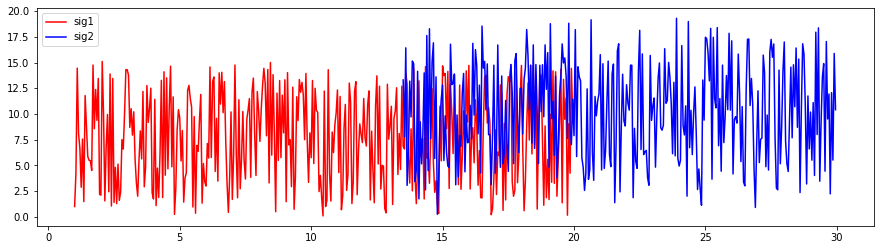

In [189]:
# defining signals

def f(x):
    return 1/x

time1 = np.arange(1, 20, 0.05)
noise = np.random.rand(time1.size)*15
sig1 = f(time1)+noise

distance = 10
a = 50
b = time1.size

time2 = time1[a:b] + distance 
sig2 = sig1[a:b] + 5*np.random.rand(time2.size)

# df1 = pd.DataFrame({'time': time1, 'sig1': sig1})
# df2 = pd.DataFrame({'time': time2, 'sig2': sig2})
# df = pd.merge(df1,df2,on='time',how='outer')
# sig1 = df.sig1.values.copy()
# sig2 = df.sig2.values.copy()

plt.figure(figsize=(15,4))
plt.plot(time1, sig1, c='r', label='sig1')
plt.plot(time2, sig2, c='b', label='sig2')
plt.legend()

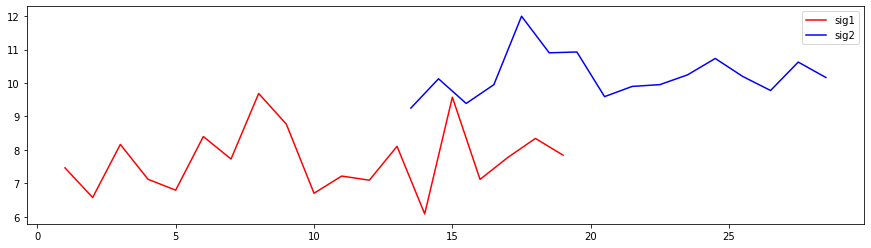

In [190]:
sig1_filt, time1_filt = aggregate(sig1, time1, 1)
sig2_filt, time2_filt = aggregate(sig2, time2, 1)

plt.figure(figsize=(15,4))
plt.plot(time1_filt, sig1_filt, c='r', label='sig1')
plt.plot(time2_filt, sig2_filt, c='b', label='sig2')
plt.legend()

## Cross correlation

In [191]:
def cross_correlation(sig1, sig2, time1=None, time2=None, debug=False):
    """ 
    Cross-correlation is given by:
    
        c(sig1, sig2)[k] = sum(sig1[n+k] * sig2[n])
        
    for k in [-len(sig2)+1, len(sig1)-1]. Basically,
    it takes signal 1 and slide it until its first value
    aligns with signal 2 last value. Then it slides it to
    to the left until signal 1 last value aligns with signal
    2 last value, as shown below:
    
        sig1  1 2 3 4 5
        sig2  1 2 3 4
        
        c[-3] = 4  ->                1 2 3 4 5
                               1 2 3 4
                               
                      
        c[-2] = 11 ->              1 2 3 4 5
                               1 2 3 4
                               
                         
        c[0]  = 30 ->          1 2 3 4 5
                               1 2 3 4
                               
                          
        c[4]  = 5  ->  1 2 3 4 5
                               1 2 3 4
                               
    The displacement with maximum correlated id obtained
    with np.argmax and then the distance of this displacement
    from the begginning of the signal 1 is calculated. That value
    is returned. For the example above, the returned value
    would be 0.
        
    If the timestamps of both signals are fed into the function,
    then the value returned is the difference, in the same time
    units:
        
        deltaT = [signal 2 beggin time] - [signal 1 max displacement time]
        
    deltaT can be interpreted as the delay of signal 2 timestamp 
    relative to signal 1 timestamp.
        
    If one wants to adjust both timestamps they can:
        
        1. add deltaT to all signal 1 timestamps; OR
        2. subtract deltaT from all signal 2 timestamps
        
    This way both signals will be synchronized according to 
    signal 1 timestamp (first case) or signal 2 timestamp
    (second case).
        
    Args:
        sig1  -- 1D numpy array with signal 1.
        
        sig2  -- 1D numpy array with signal 2.
        
        time1 -- Optional (default=None). 1D numpy array with signal 1 timestamps.
        
        time2 -- Optional (default=None). 1D numpy array with signal 2 timestamps.
        
        debug -- Optional (default=False). True for displaying a plot of the cross correlation
        as a function of the displacement.
        
    Returns:
        max_disp if time1 or time2 equals None, otherwise returns time_diff.
                      
    """
    crosscorr = correlate(sig1, sig2, 'full')
    max_disp = np.argmax(crosscorr) - len(sig2) + 1
    
    if debug:
        xaxis = np.arange(0,len(crosscorr)) - len(sig2) + 1
        plt.figure()
        plt.plot(xaxis, crosscorr)
        plt.axvline(max_disp, c='r', label=f'Max (d = {max_disp})', alpha=0.6)
        plt.title('Cross Correlation', FontSize=14)
        plt.ylabel('correlation', FontSize=14)
        plt.xlabel('displacement', FontSize=14)
        plt.legend()
    
    if (time1 is not None) and (time2 is not None):
        time_diff = time2[0] - time1[max_disp]
        if debug:
            print(f'time short start - time short actual start = {time_diff}')
        return time_diff
    
    return max_disp

time short start - time short actual start = 10.0


10.0

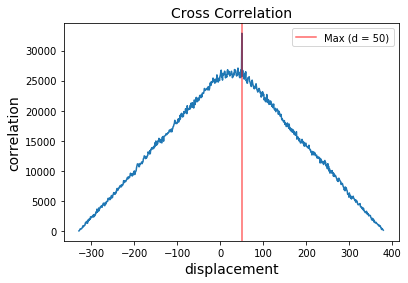

In [192]:
cross_correlation(sig1, sig2, time1, time2, debug=True)

time short start - time short actual start = 10.0


10.0

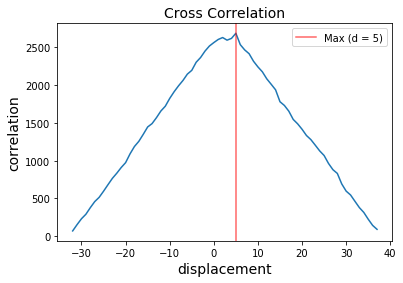

In [193]:
sig1_filt, time1_filt = aggregate(sig1, time1, .5)
sig2_filt, time2_filt = aggregate(sig2, time2, .5)
cross_correlation(sig1_filt, sig2_filt, time1_filt, time2_filt, debug=True)

## Pearson's correlation

In [194]:
def correlation(sig1, sig2):
    return np.corrcoef(sig1, sig2)[0,1]

# def slide(sig_static, sig_slide, f=correlation):
#     res_size = len(sig_static) + len(sig_slide) - 1
#     res = np.zeros(res_size)
    
#     index = 0
#     for i in range(0, len(sig_slide)):
#         slide_idx = len(sig_slide) - i - 1
#         static_idx = i + 1
#         res[index] = f(sig_static[:static_idx], sig_slide[slide_idx:])
#         index += 1
        
#     for i in range(1, len(sig_static) - len(sig_slide) + 1):
#         static_idx = i + len(sig_slide)
#         res[index] = f(sig_static[i:static_idx], sig_slide)
#         index += 1
        
#     for i in range(1, len(sig_slide)):
#         slide_idx = len(sig_slide) - i
#         static_idx = len(sig_static) - len(sig_slide) + i
#         res[index] = f(sig_static[static_idx:], sig_slide[:slide_idx])
#         index += 1
    
#     res[np.isnan(res)] = 0
    
#     return res
 
# def pearson_correlation(sig1, sig2, time1=None, time2=None, debug=False):
#     pcorr = slide(sig1, sig2)
#     max_disp = np.argmax(pcorr) - len(sig2) + 1
    
#     if debug:
#         xaxis = np.arange(0,len(pcorr)) - len(sig2) + 1
#         plt.figure()
#         plt.plot(xaxis, pcorr)
#         plt.axvline(max_disp, c='r', label=f'Max (d = {max_disp})', alpha=0.6)
#         plt.title('Pearson Correlation', FontSize=14)
#         plt.ylabel('correlation', FontSize=14)
#         plt.xlabel('displacement', FontSize=14)
#         plt.legend()
    
#     if (time1 is not None) and (time2 is not None):
#         time_diff = time2[0] - time1[max_disp]
#         if debug:
#             print(f'time short start - time short actual start = {time_diff}')
#         return time_diff
    
#     return max_disp

In [195]:
def slide(sig_static, sig_slide, f=correlation):
    res_size = len(sig_static) + len(sig_slide) - 1
    res = np.zeros(res_size)
    
    index = 0
    for i in range(0, len(sig_slide)):
        slide_idx = len(sig_slide) - i - 1
        static_idx = i + 1
        res[index] = f(sig_static[:static_idx], sig_slide[slide_idx:])
        index += 1
        
    for i in range(1, len(sig_static) - len(sig_slide) + 1):
        static_idx = i + len(sig_slide)
        res[index] = f(sig_static[i:static_idx], sig_slide)
        index += 1
        
    for i in range(1, len(sig_slide)):
        slide_idx = len(sig_slide) - i
        static_idx = len(sig_static) - len(sig_slide) + i
        res[index] = f(sig_static[static_idx:], sig_slide[:slide_idx])
        index += 1
    
    res[np.isnan(res)] = 0
    
    return res

def pearson_correlation(sig1, sig2, time1=None, time2=None, cut=(0, 0), debug=False):
    pcorr = slide(sig1, sig2)
    pcorr_cut = pcorr.copy()
    pcorr_cut[:cut[0]] = 0
    pcorr_cut[pcorr_cut.size-cut[1]:] = 0
    max_disp = np.argmax(pcorr_cut) - len(sig2) + 1
    
    if debug:
        xaxis = np.arange(0,len(pcorr)) - len(sig2) + 1
        plt.figure()
        plt.plot(xaxis, pcorr_cut)
        plt.axvline(max_disp, c='r', label=f'Max (d = {max_disp})', alpha=0.6)
        plt.title('Pearson Correlation', FontSize=14)
        plt.ylabel('correlation', FontSize=14)
        plt.xlabel('displacement', FontSize=14)
        plt.legend()
    
    if (time1 is not None) and (time2 is not None):
        time_diff = time2[0] - time1[max_disp]
        if debug:
            print(f'time short start - time short actual start = {time_diff}')
        return time_diff
    
    return max_disp

time short start - time short actual start = 10.0


10.0

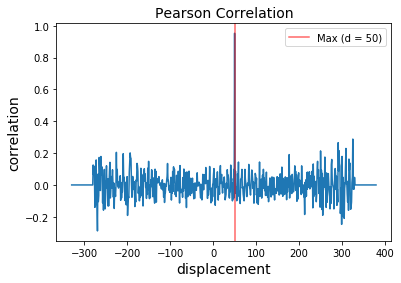

In [197]:
pearson_correlation(sig1, sig2, time1, time2, debug=True, cut=(50 ,50))

time short start - time short actual start = 10.0


10.0

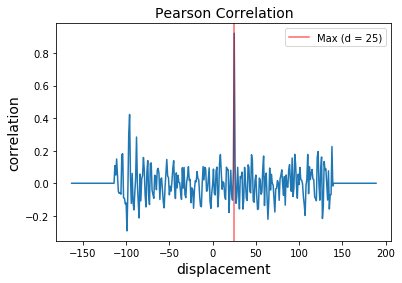

In [198]:
sig1_filt, time1_filt = aggregate(sig1, time1, .1)
sig2_filt, time2_filt = aggregate(sig2, time2, .1)
pearson_correlation(sig1_filt, sig2_filt, time1_filt, time2_filt, debug=True, cut=(50,50))

## Dynamic Time Warping

In [199]:
d

159.07557481401204

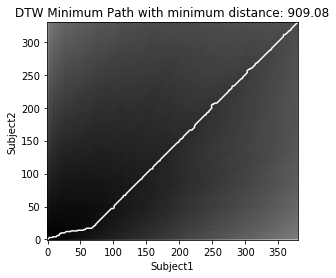

In [200]:
from dtw import dtw,accelerated_dtw

d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(sig1,sig2, dist='euclidean')

plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlabel('Subject1')
plt.ylabel('Subject2')
plt.title(f'DTW Minimum Path with minimum distance: {np.round(d,2)}')
plt.show()

In [201]:
def slide(sig_static, sig_slide):
    res_size = len(sig_static) + len(sig_slide) - 1
    res = np.zeros(res_size)
    
    index = 0
    for i in range(0, len(sig_slide)):
        slide_idx = len(sig_slide) - i - 1
        static_idx = i + 1
        res[index], _, _, _ = accelerated_dtw(sig_static[:static_idx], sig_slide[slide_idx:], dist='euclidean')
        index += 1
        
    for i in range(1, len(sig_static) - len(sig_slide) + 1):
        static_idx = i + len(sig_slide)
        res[index], _, _, _ = accelerated_dtw(sig_static[i:static_idx], sig_slide, dist='euclidean')
        index += 1
        
    for i in range(1, len(sig_slide)):
        slide_idx = len(sig_slide) - i
        static_idx = len(sig_static) - len(sig_slide) + i
        res[index], _, _, _ = accelerated_dtw(sig_static[static_idx:], sig_slide[:slide_idx], dist='euclidean')
        index += 1
    
    res[np.isnan(res)] = 0
    
    return res

def dtw_correlation(sig1, sig2, time1=None, time2=None, cut=(0, 0), debug=False):
    pcorr = slide(sig1, sig2)
    pcorr_cut = pcorr.copy()
    pcorr_cut[:cut[0]] = 0
    pcorr_cut[pcorr_cut.size-cut[1]:] = 0
    max_disp = np.argmin(pcorr_cut) - len(sig2) + 1
    
    if debug:
        xaxis = np.arange(0,len(pcorr)) - len(sig2) + 1
        plt.figure()
        plt.plot(xaxis, pcorr_cut)
        plt.axvline(max_disp, c='r', label=f'Min (d = {max_disp})', alpha=0.6)
        plt.title('DTW', FontSize=14)
        plt.ylabel('correlation', FontSize=14)
        plt.xlabel('displacement', FontSize=14)
        plt.legend()
    
    if (time1 is not None) and (time2 is not None):
        time_diff = time2[0] - time1[max_disp]
        if debug:
            print(f'time short start - time short actual start = {time_diff}')
        return time_diff
    
    return max_disp

time short start - time short actual start = 10.0


10.0

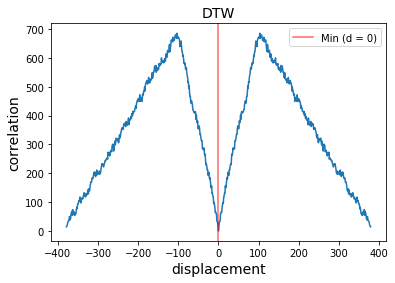

In [169]:
dtw_correlation(sig1, sig2, time1, time2, debug=True, cut=(0, 0))

time short start - time short actual start = -6.000000000000016


-6.000000000000016

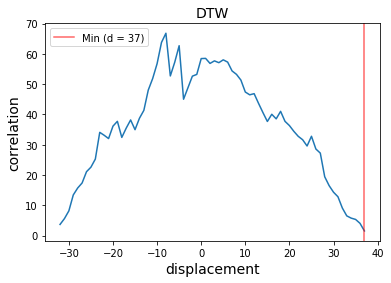

In [202]:
sig1_filt, time1_filt = aggregate(sig1, time1, .5)
sig2_filt, time2_filt = aggregate(sig2, time2, .5)
dtw_correlation(sig1_filt, sig2_filt, time1_filt, time2_filt, debug=True, cut=(0, 0))

## Distribution distance